# Using Pretrained Inception-BatchNorm Network

In this example we will show how to use a pretrained *Inception-BatchNorm* Network. This network is described in the paper

> Ioffe, Sergey, and Christian Szegedy. "Batch normalization: Accelerating deep network training by reducing internal covariate shift." arXiv preprint arXiv:1502.03167 (2015).

The pre-trained Inception-BatchNorm network is able to be downloaded from [this link](http://webdocs.cs.ualberta.ca/~bx3/data/Inception.zip). Run the script `get.sh` in `models/Inception/` will download and unpack it automatically.

Let us first load and display the demo image (try to use other images you like). You will need to install `Images.jl` and `Colors.jl` to load the image.

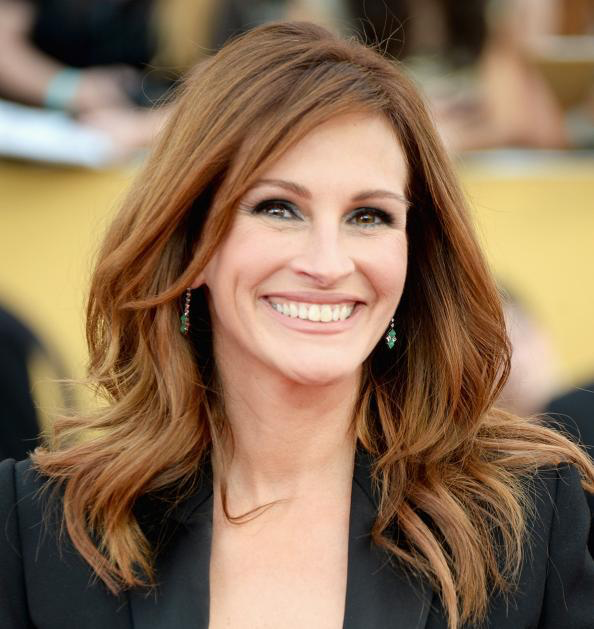

In [106]:
using Images, Colors
#img = imread("cat.png")
img = imread("/Users/chiyuan/Desktop/bird.png")
img = imread("/Users/chiyuan/Desktop/bill-gates.jpg")
#img = imread("/Users/chiyuan/Desktop/dog.jpg")
#img = imread("/Users/chiyuan/Desktop/schoolbus.jpg")
#img = imread("/Users/chiyuan/Desktop/horse-face-2.jpg")

Now let us do some preprocessing. The most important thing is to resize image to 224x224 that the pre-trained neural network model expect. However, since `Images.jl` does not have a `imresize` function yet, we will call Python to do the preprocessing. The helper function is defined in `imagehelper.py` under the same directory.

In [107]:
img = convert(Array, separate(convert(Image{RGB}, img)))
using PyCall
unshift!(PyVector(pyimport("sys")["path"]), "")
@pyimport imagehelper as helper

img = helper.PreprocessImage(img)
# transform from Python row-major to Julia column-major
img = permutedims(img, [3,2,1])
println("Image resized to $(size(img))")

Image resized to (224,224,3)
('Original Image Shape: ', (629, 594, 3))


The last thing we need to do to prepare the image is to subtract it from the mean. The mean image is computed on the training set, and it comes with the pre-trained model archive.

In [108]:
using MXNet

model_dir = joinpath(Pkg.dir("MXNet"), "models/Inception/Inception/")
mean_file = joinpath(model_dir, "mean_224.nd")
mean_arr  = mx.load(mean_file, mx.NDArray)[:mean_img]

img       = img - copy(mean_arr)
img       = reshape(img, 224, 224, 3, 1) # add a mini-batch dim
println("Image prepared!")

Image prepared!


Now we can load the pre-trained model, via the `load_checkpoint` function.

In [109]:
model_prefix = joinpath(model_dir, "Inception_BN")
model_epoch  = 39
model        = mx.load_checkpoint(model_prefix, model_epoch, mx.FeedForward)
println("Model loaded")

Model loaded


With the loaded model, we can do prediction by wrapping the image with a `ArrayDataProvider`. The output is a 1000-way vector giving the predicted probability of each class. The class names are read from `synset.txt`, and we show the class name with the maximum probability.

In [110]:
pred = mx.predict(model, mx.ArrayDataProvider(img))
classes = open(joinpath(model_dir, "synset.txt")) do s 
    map(x -> replace(strip(x), r"^n[0-9]+ ", ""), readlines(s))
end
println(classes[indmax(pred)])

wig


We can also show easily the top-5 classes and the associated probabilities.

In [111]:
K = 5
n_best = sortperm(vec(pred), rev=true)[1:K]
best_probs = pred[n_best]
best_labels = classes[n_best]

for (l,p) in zip(best_labels, best_probs)
    println(mx.format("{1:>18} w.p. {2:4f}", l, p))
end

               wig w.p. 0.430989
  feather boa, boa w.p. 0.127852
          fur coat w.p. 0.112760
        hair spray w.p. 0.055442
             cloak w.p. 0.019644
